In [17]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage,  fcluster
from sklearn.metrics import silhouette_score
import datetime as dt
import numpy as np

# Read the CSV file
grouped2 = pd.read_csv('../../processed_data/Second_dataset/New_dataset_Merchant_corresponding_incomes.csv')

In [3]:
grouped2

,Third Party Name,Account No,Balance,Amount,Datetime,Transaction Type
0,a cut above,104832000.0,-2441.204859,-200.00,2023-08-08 15:37:00,Income
1,a yarn story,969804197.0,814.130000,-43.96,2023-01-01 12:19:00,Income
2,a yarn story,441142605.0,1182.262700,-7.98,2023-01-02 09:38:00,Income
3,a yarn story,687135796.0,1059.382100,-26.97,2023-01-04 11:15:00,Income
4,a yarn story,263882093.0,439.691500,-38.50,2023-01-04 15:17:00,Income
...,...,...,...,...,...,...
215348,xbox,331450202.0,9706.489072,-7.00,2023-11-30 23:59:00,Income
215349,xbox,575652395.0,2192.938098,-7.00,2023-11-30 23:59:00,Income
215350,xbox,574548998.0,237.865050,-7.00,2023-11-30 23:59:00,Income
215351,xbox,586041848.0,2880.694700,-7.00,2023-11-30 23:59:00,Income


In [4]:
grouped2['Datetime'] = pd.to_datetime(grouped2['Datetime'])
current_date = grouped2['Datetime'].max()

rfm = grouped2.groupby(['Third Party Name', 'Account No']).agg({
    'Datetime': lambda x: (current_date - x.max()).days,  # Recency
    'Account No': 'count',                                        # Frequency
    'Amount': lambda x: -x.sum()                                    # Monetary
}).rename(columns={
    'Datetime': 'recency',
    'Account No': 'frequency',
    'Amount': 'monetary'
}).reset_index()

In [26]:
rfm = rfm.groupby('Third Party Name').filter(lambda x: len(x) > 2 and x[['recency', 'frequency', 'monetary']].std().sum() > 0)

rfm_labels_df = pd.DataFrame()
best_ks = []

for third_party_name in rfm['Third Party Name'].unique():
    account_rfm = rfm[rfm['Third Party Name'] == third_party_name]
    
    # 数据标准化
    scaler = StandardScaler()
    rfm_scaled = scaler.fit_transform(account_rfm[['recency', 'frequency', 'monetary']])
    
    # 执行层次聚类
    linked = linkage(rfm_scaled, method='ward')
    
    # 确保有足够的数据点进行多聚类分析
    if len(account_rfm) > 1:
        # 尝试不同的聚类数，并计算轮廓系数
        silhouette_scores = []
        max_clusters = min(len(account_rfm), 10)  # 聚类数上限为10或样本数
        for k in range(2, max_clusters + 1):
            labels = fcluster(linked, k, criterion='maxclust')
            if len(set(labels)) > 1:  # 确保有超过一类
                score = silhouette_score(rfm_scaled, labels)
                silhouette_scores.append(score)
            else:
                silhouette_scores.append(-1)

        if silhouette_scores:
            # 找到轮廓系数最高的聚类数
            best_k = np.argmax(silhouette_scores) + 2
            print(f"Best number of clusters for {third_party_name}: {best_k}")
            best_ks.append(best_k)

            # 使用最佳聚类数进行最终聚类
            final_labels = fcluster(linked, best_k, criterion='maxclust')
            account_rfm['Cluster'] = final_labels
            account_rfm['Cluster_Label'] = ['Label_' + str(label) for label in final_labels]
            rfm_labels_df = pd.concat([rfm_labels_df, account_rfm], ignore_index=True)
    else:
        print(f"Not enough data for clustering in {third_party_name}")

# 展示聚类结果
print(rfm_labels_df.head())

Best number of clusters for a yarn story: 10
Best number of clusters for amazon: 3
Best number of clusters for blackwell's: 4
Best number of clusters for blizzard: 2
Best number of clusters for boots: 3


/var/folders/n3/6xqnn4v12njfydy7nrm670yh0000gn/T/ipykernel_84737/1355643062.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  account_rfm['Cluster'] = final_labels
/var/folders/n3/6xqnn4v12njfydy7nrm670yh0000gn/T/ipykernel_84737/1355643062.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  account_rfm['Cluster_Label'] = ['Label_' + str(label) for label in final_labels]
/var/folders/n3/6xqnn4v12njfydy7nrm670yh0000gn/T/ipykernel_84737/1355643062.py:37: SettingWithCopyWarning: 
A value is trying to be set

Best number of clusters for brilliant brushes: 2
Best number of clusters for cass art: 2
Best number of clusters for cex: 2
Best number of clusters for coffee #1: 2
Best number of clusters for collector cave: 2
Best number of clusters for coop local: 2
Best number of clusters for costa coffee: 3
Best number of clusters for craftastic: 4
Best number of clusters for deliveroo: 2
Best number of clusters for disney: 4


/var/folders/n3/6xqnn4v12njfydy7nrm670yh0000gn/T/ipykernel_84737/1355643062.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  account_rfm['Cluster'] = final_labels
/var/folders/n3/6xqnn4v12njfydy7nrm670yh0000gn/T/ipykernel_84737/1355643062.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  account_rfm['Cluster_Label'] = ['Label_' + str(label) for label in final_labels]
/var/folders/n3/6xqnn4v12njfydy7nrm670yh0000gn/T/ipykernel_84737/1355643062.py:37: SettingWithCopyWarning: 
A value is trying to be set

Best number of clusters for etsy: 2
Best number of clusters for fat face: 3
Best number of clusters for fitted stitch: 3
Best number of clusters for five senses art: 3
Best number of clusters for foyles: 2
Best number of clusters for gamestation: 2
Best number of clusters for grand union bjj: 3
Best number of clusters for halifax: 2


/var/folders/n3/6xqnn4v12njfydy7nrm670yh0000gn/T/ipykernel_84737/1355643062.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  account_rfm['Cluster'] = final_labels
/var/folders/n3/6xqnn4v12njfydy7nrm670yh0000gn/T/ipykernel_84737/1355643062.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  account_rfm['Cluster_Label'] = ['Label_' + str(label) for label in final_labels]
/var/folders/n3/6xqnn4v12njfydy7nrm670yh0000gn/T/ipykernel_84737/1355643062.py:37: SettingWithCopyWarning: 
A value is trying to be set

Best number of clusters for hobby lobby: 2
Best number of clusters for hobbycraft: 2
Best number of clusters for jd sports: 4
Best number of clusters for justeat: 2
Best number of clusters for kew house: 2
Best number of clusters for kings arms: 3
Best number of clusters for lavender primary: 2
Best number of clusters for lbg: 2
Best number of clusters for lloyds pharmacy: 3
Best number of clusters for loosely fitted: 3
Best number of clusters for mamas & papas: 2


/var/folders/n3/6xqnn4v12njfydy7nrm670yh0000gn/T/ipykernel_84737/1355643062.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  account_rfm['Cluster'] = final_labels
/var/folders/n3/6xqnn4v12njfydy7nrm670yh0000gn/T/ipykernel_84737/1355643062.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  account_rfm['Cluster_Label'] = ['Label_' + str(label) for label in final_labels]
/var/folders/n3/6xqnn4v12njfydy7nrm670yh0000gn/T/ipykernel_84737/1355643062.py:37: SettingWithCopyWarning: 
A value is trying to be set

Best number of clusters for matalan: 2
Best number of clusters for mojang studios: 10
Best number of clusters for netflix: 5
Best number of clusters for puregym: 4


/var/folders/n3/6xqnn4v12njfydy7nrm670yh0000gn/T/ipykernel_84737/1355643062.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  account_rfm['Cluster'] = final_labels
/var/folders/n3/6xqnn4v12njfydy7nrm670yh0000gn/T/ipykernel_84737/1355643062.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  account_rfm['Cluster_Label'] = ['Label_' + str(label) for label in final_labels]
/var/folders/n3/6xqnn4v12njfydy7nrm670yh0000gn/T/ipykernel_84737/1355643062.py:37: SettingWithCopyWarning: 
A value is trying to be set

Best number of clusters for reebok: 4
Best number of clusters for revella: 4
Best number of clusters for rose & crown: 4
Best number of clusters for sainsbury: 2
Best number of clusters for sainsbury local: 2
Best number of clusters for selfridges: 3


/var/folders/n3/6xqnn4v12njfydy7nrm670yh0000gn/T/ipykernel_84737/1355643062.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  account_rfm['Cluster'] = final_labels
/var/folders/n3/6xqnn4v12njfydy7nrm670yh0000gn/T/ipykernel_84737/1355643062.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  account_rfm['Cluster_Label'] = ['Label_' + str(label) for label in final_labels]
/var/folders/n3/6xqnn4v12njfydy7nrm670yh0000gn/T/ipykernel_84737/1355643062.py:37: SettingWithCopyWarning: 
A value is trying to be set

Best number of clusters for sports direct: 4
Best number of clusters for squareonix: 10
Best number of clusters for starbucks: 3
Best number of clusters for stitch by stitch: 2
Best number of clusters for tesco: 2


/var/folders/n3/6xqnn4v12njfydy7nrm670yh0000gn/T/ipykernel_84737/1355643062.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  account_rfm['Cluster'] = final_labels
/var/folders/n3/6xqnn4v12njfydy7nrm670yh0000gn/T/ipykernel_84737/1355643062.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  account_rfm['Cluster_Label'] = ['Label_' + str(label) for label in final_labels]
/var/folders/n3/6xqnn4v12njfydy7nrm670yh0000gn/T/ipykernel_84737/1355643062.py:37: SettingWithCopyWarning: 
A value is trying to be set

Best number of clusters for the crown: 6
Best number of clusters for the works: 2
Best number of clusters for topshop: 3
Best number of clusters for wool: 3
Best number of clusters for xbox: 3
  Third Party Name   Account No  recency  frequency  monetary  Cluster  \
0     a yarn story  128033695.0       16         15    292.60        8   
1     a yarn story  138969884.0      158          1     47.84        1   
2     a yarn story  221868392.0      319          1      2.99        2   
3     a yarn story  228136274.0      281          1     33.00        2   
4     a yarn story  235881534.0      319          1    134.85        2   

  Cluster_Label  
0       Label_8  
1       Label_1  
2       Label_2  
3       Label_2  
4       Label_2  


/var/folders/n3/6xqnn4v12njfydy7nrm670yh0000gn/T/ipykernel_84737/1355643062.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  account_rfm['Cluster'] = final_labels
/var/folders/n3/6xqnn4v12njfydy7nrm670yh0000gn/T/ipykernel_84737/1355643062.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  account_rfm['Cluster_Label'] = ['Label_' + str(label) for label in final_labels]
/var/folders/n3/6xqnn4v12njfydy7nrm670yh0000gn/T/ipykernel_84737/1355643062.py:37: SettingWithCopyWarning: 
A value is trying to be set

In [28]:
median_k = np.median(best_ks)
mode_k = pd.Series(best_ks).mode()[0]
mean_k = np.mean(best_ks)
print(median_k,mode_k,mean_k)

3.0 2 3.185185185185185


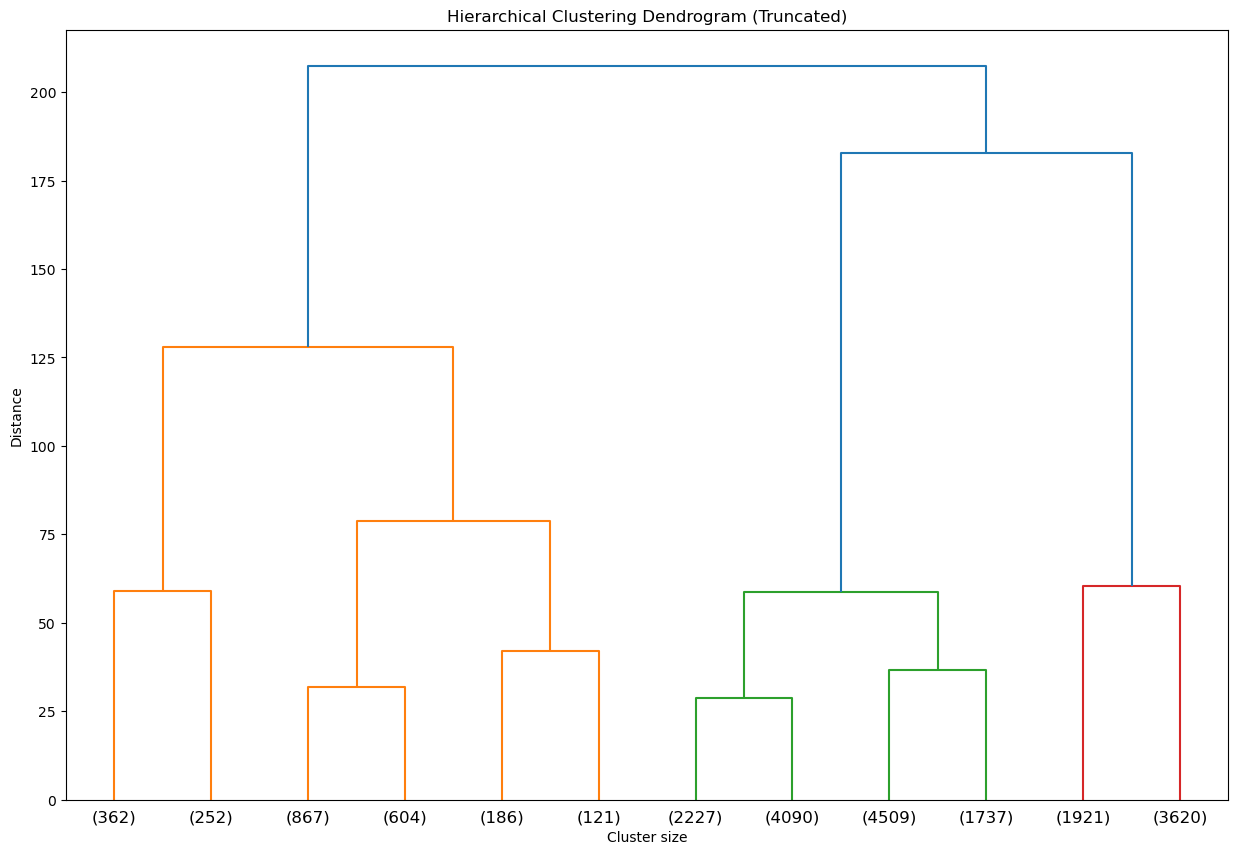

  Third Party Name   Account No  recency  frequency  monetary  Cluster  \
1     a yarn story  128033695.0       16         15    292.60        2   
2     a yarn story  138969884.0      158          1     47.84        3   
3     a yarn story  221868392.0      319          1      2.99        3   
4     a yarn story  228136274.0      281          1     33.00        3   
5     a yarn story  235881534.0      319          1    134.85        3   

  Cluster_Label  
1     Cluster_2  
2     Cluster_3  
3     Cluster_3  
4     Cluster_3  
5     Cluster_3  

Cluster 1:
Average Recency: 7.324832775919733
Average Frequency: 36.538879598662206
Average Monetary: 4135.37043896321
Total number: 2392

Cluster 2:
Average Recency: 28.061927883467323
Average Frequency: 8.981453474488578
Average Monetary: 359.47649844782296
Total number: 12563

Cluster 3:
Average Recency: 251.85489983757444
Average Frequency: 2.7244179750947484
Average Monetary: 142.39680202129577
Total number: 5541


In [32]:
# 对整个数据集进行标准化
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['recency', 'frequency', 'monetary']])

# 执行层次聚类
linked = linkage(rfm_scaled, method='ward')

# 使用全局聚类数进行聚类
global_k = 3  
labels = fcluster(linked, global_k, criterion='maxclust')

# 可视化树状图
plt.figure(figsize=(15, 10))
dendrogram(linked, truncate_mode='lastp', p=12)
plt.title('Hierarchical Clustering Dendrogram (Truncated)')
plt.xlabel('Cluster size')
plt.ylabel('Distance')
plt.show()

# 将聚类结果添加到原始数据框
rfm['Cluster'] = labels
rfm['Cluster_Label'] = ['Cluster_' + str(label) for label in labels]

# 展示聚类结果
print(rfm.head())

# 分析每个聚类的特征
for i in range(1, global_k + 1):
    cluster_data = rfm[rfm['Cluster'] == i]
    print(f"\nCluster {i}:")
    print("Average Recency:", cluster_data['recency'].mean())
    print("Average Frequency:", cluster_data['frequency'].mean())
    print("Average Monetary:", cluster_data['monetary'].mean())
    print("Total number:", len(cluster_data))

In [39]:
unique_clusters = np.unique(labels)
cluster_summary = rfm.groupby('Cluster').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': 'mean'
}).reset_index()

# 手动分配聚类标签，类似之前的逻辑
cluster_summary.sort_values(by='monetary', ascending=False, inplace=True)
cluster_labels = {}
cluster_labels[cluster_summary.iloc[0, 0]] = 'High-Value Customers'

# 分辨剩余聚类
if cluster_summary.iloc[1, 1] >= cluster_summary.iloc[2, 1]:
    cluster_labels[cluster_summary.iloc[1, 0]] = 'Developing Customers'
    cluster_labels[cluster_summary.iloc[2, 0]] = 'Low-Value/Risky Customers'
else:
    cluster_labels[cluster_summary.iloc[2, 0]] = 'Developing Customers'
    cluster_labels[cluster_summary.iloc[1, 0]] = 'Low-Value/Risky Customers'

# 映射聚类标签回原始数据框
rfm['Cluster_Label'] = rfm['Cluster'].map(cluster_labels)

# 输出聚类摘要和数据帧头部
print(cluster_summary)
print(rfm.head())

   Cluster     recency  frequency     monetary
0        1    7.324833  36.538880  4135.370439
1        2   28.061928   8.981453   359.476498
2        3  251.854900   2.724418   142.396802
  Third Party Name   Account No  recency  frequency  monetary  Cluster  \
1     a yarn story  128033695.0       16         15    292.60        2   
2     a yarn story  138969884.0      158          1     47.84        3   
3     a yarn story  221868392.0      319          1      2.99        3   
4     a yarn story  228136274.0      281          1     33.00        3   
5     a yarn story  235881534.0      319          1    134.85        3   

               Cluster_Label  
1  Low-Value/Risky Customers  
2       Developing Customers  
3       Developing Customers  
4       Developing Customers  
5       Developing Customers  


In [40]:
rfm.to_csv('rfm.csv', index=False)